In [1]:
library(tidyverse)
library(RColorBrewer)
library(DESeq2)
library(pheatmap)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The follow

In [2]:
setwd('/ufrc/soltis/shan158538/TragFL_NewAnalysis/OutPut/DE_analysis/DE_Tdu_Tpr')

In [3]:
## Loading data
data <- read.table("DESeq2_count_matrix_Tdu_Tpr.csv", sep=",",header = T,row.names=1)
meta <- read.csv("DESeq2_Tdu_Tpr_sample_annotation.tsv", sep = "\t", row.names="sample")
## first column is row names: row.names = 1

In [4]:
head(data)

,Tdu_1,Tdu_2,Tdu_3,Tdu_4,Tdu_5,Tdu_6,Tpr_1,Tpr_2,Tpr_3
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Tpr_TRINITY_DN11257_c2_g1|Tdu_TRINITY_DN16696_c0_g1,92,109,123,106,116,121,103,173,78
Tpr_TRINITY_DN10844_c2_g7|Tdu_TRINITY_DN25328_c2_g5,157,218,281,177,169,238,204,402,205
Tpr_TRINITY_DN15383_c4_g16|Tdu_TRINITY_DN14160_c0_g1,36,64,58,43,36,47,21,25,18
Tpr_TRINITY_DN1451_c0_g1|Tdu_TRINITY_DN16990_c3_g1,96,140,142,80,126,108,141,200,119
Tpr_TRINITY_DN10853_c1_g4|Tdu_TRINITY_DN21860_c3_g3,773,1099,976,809,1113,918,751,1281,700
Tpr_TRINITY_DN12798_c2_g2|Tdu_TRINITY_DN24179_c2_g3,50,46,72,28,48,39,35,118,55


In [5]:
meta

,species,population
,<fct>,<fct>
Tdu_1,Tdu,Tdu_pullman
Tdu_2,Tdu,Tdu_pullman
Tdu_3,Tdu,Tdu_pullman
Tdu_4,Tdu,Tdu_moscow
Tdu_5,Tdu,Tdu_moscow
Tdu_6,Tdu,Tdu_moscow
Tpr_1,Tpr,Tpr_moscow
Tpr_2,Tpr,Tpr_moscow
Tpr_3,Tpr,Tpr_moscow


## 1. RNA-seq count distribution
### To determine the appropriate statistical model, we need information about the distribution of counts.

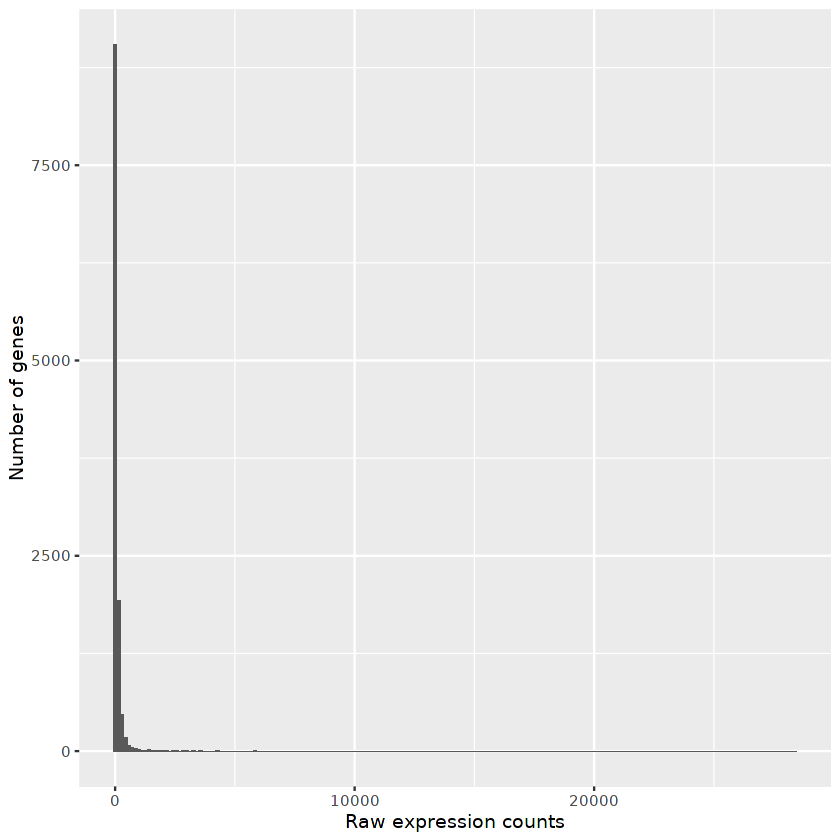

In [6]:
## Here showed read counts distribution of sample Tdu_1
ggplot(data) +
  geom_histogram(aes(x = Tdu_1), stat = "bin", bins = 200) +
  xlab("Raw expression counts") +
  ylab("Number of genes")

These images illustrate some common features of RNA-seq count data, including a low number of counts associated with a large proportion of genes, and a long right tail due to the lack of any upper limit for expression.

## 2. Moduling count data
### **Negative Binomial (NB) model**; the NB model is a good approximation for data where the mean < variance, as is the case with RNA-Seq count data

Plot the mean versus the variance of your data

In [7]:
head(data[, 1:3])
## indicates Tdu_pullman data

,Tdu_1,Tdu_2,Tdu_3
,<int>,<int>,<int>
Tpr_TRINITY_DN11257_c2_g1|Tdu_TRINITY_DN16696_c0_g1,92,109,123
Tpr_TRINITY_DN10844_c2_g7|Tdu_TRINITY_DN25328_c2_g5,157,218,281
Tpr_TRINITY_DN15383_c4_g16|Tdu_TRINITY_DN14160_c0_g1,36,64,58
Tpr_TRINITY_DN1451_c0_g1|Tdu_TRINITY_DN16990_c3_g1,96,140,142
Tpr_TRINITY_DN10853_c1_g4|Tdu_TRINITY_DN21860_c3_g3,773,1099,976
Tpr_TRINITY_DN12798_c2_g2|Tdu_TRINITY_DN24179_c2_g3,50,46,72


Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous x-axis”


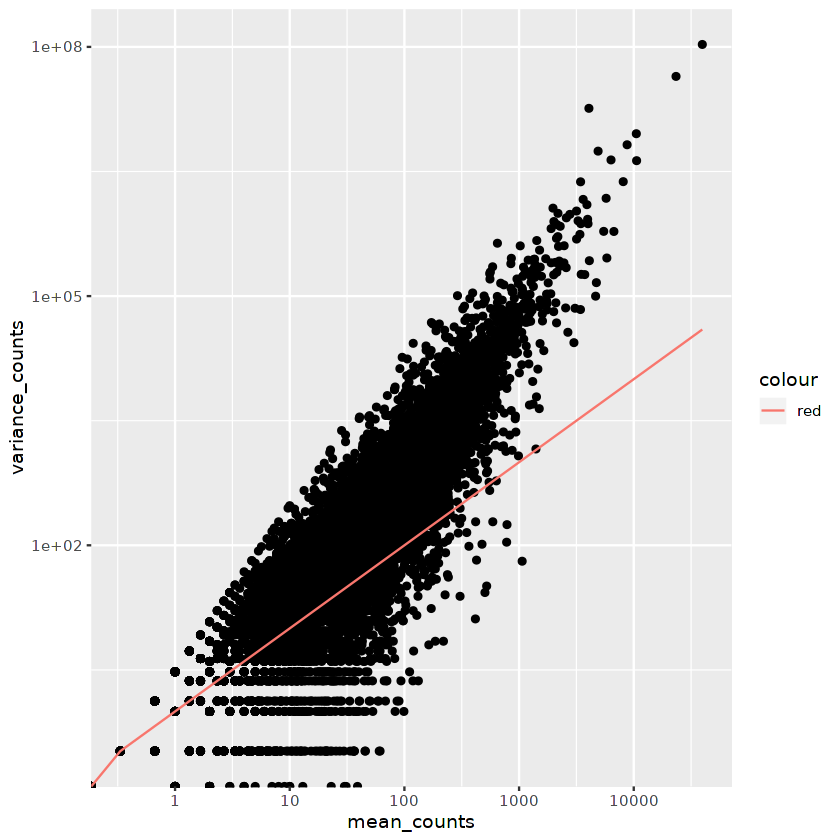

In [8]:
mean_counts <- apply(data[, 1:3], 1, mean)
variance_counts <- apply(data[, 1:3], 1, var)
df <- data.frame(mean_counts, variance_counts)
ggplot(df) +
        geom_point(aes(x=mean_counts, y=variance_counts)) + 
        geom_line(aes(x=mean_counts, y=mean_counts, color="red")) +
        scale_y_log10() +
        scale_x_log10()

Note that in the above figure, the variance across replicates tends to be greater than the mean (red line), especially for genes with large mean expression levels. This is a good indication that our data do not fit the Poisson distribution and we need to account for this increase in variance using the Negative Binomial model.
### **DESeq2 uses the negative binomial mode**

## 3. Normalization

In [9]:
## match the metadata and counts data
all(colnames(data) %in% rownames(meta))

[1] TRUE

In [10]:
## Creat DESeq2Dataset object
dds <- DESeqDataSetFromMatrix(countData = data, colData = meta, design = ~ population)

In [11]:
## generate size factors
## By assigning the results back to the dds object we are filling in the slots of the DESeqDataSet object with the appropriate info
dds <- estimateSizeFactors(dds)

In [12]:
sizeFactors(dds)

Tdu_1     Tdu_2     Tdu_3     Tdu_4     Tdu_5     Tdu_6     Tpr_1     Tpr_2 
0.9761305 1.1888303 1.3785257 0.8577420 1.1508282 0.9517220 0.7605074 1.4226687 
    Tpr_3 
0.7018284

In [13]:
head(counts(dds, normalized=TRUE))

,Tdu_1,Tdu_2,Tdu_3,Tdu_4,Tdu_5,Tdu_6,Tpr_1,Tpr_2,Tpr_3
Tpr_TRINITY_DN11257_c2_g1|Tdu_TRINITY_DN16696_c0_g1,94.24970,91.68676,89.22576,123.58029,100.79697,127.13797,135.43590,121.60245,111.13828
Tpr_TRINITY_DN10844_c2_g7|Tdu_TRINITY_DN25328_c2_g5,160.83915,183.37353,203.84096,206.35576,146.85076,250.07303,268.24198,282.56754,292.09420
Tpr_TRINITY_DN15383_c4_g16|Tdu_TRINITY_DN14160_c0_g1,36.88032,53.83443,42.07393,50.13163,31.28182,49.38417,27.61314,17.57261,25.64730
Tpr_TRINITY_DN1451_c0_g1|Tdu_TRINITY_DN16990_c3_g1,98.34751,117.76282,103.00860,93.26814,109.48637,113.47852,185.40254,140.58087,169.55712
Tpr_TRINITY_DN10853_c1_g4|Tdu_TRINITY_DN21860_c3_g3,791.90234,924.43811,708.00277,943.17406,967.12957,964.56739,987.49866,900.42045,997.39482
Tpr_TRINITY_DN12798_c2_g2|Tdu_TRINITY_DN24179_c2_g3,51.22266,38.69350,52.22971,32.64385,41.70909,40.97835,46.02191,82.94271,78.36674


## 4. Quality control

In [14]:
## Transform normalized counts using the rlog transformation
## The rlog transformation of the normalized counts is only necessary for these visualization methods during this quality assessment
## The blind=TRUE argument results in a transformation unbiased to sample condition information
rld <- rlog(dds, blind=TRUE)

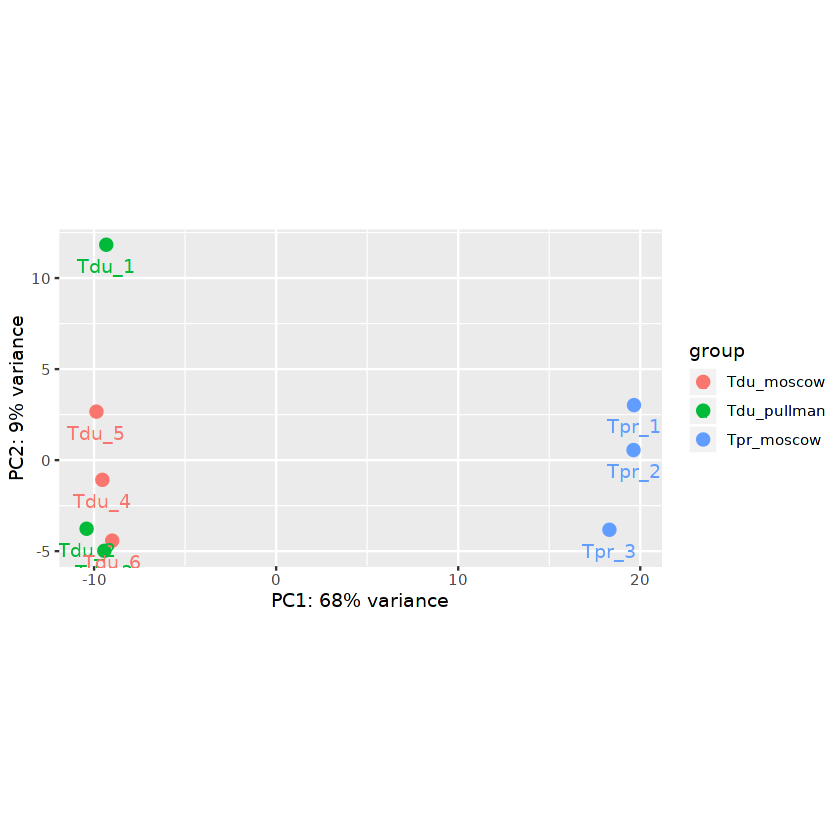

In [15]:
## Plot PCA
plotPCA(rld, intgroup="population") + geom_text(aes(label=name),vjust=2)

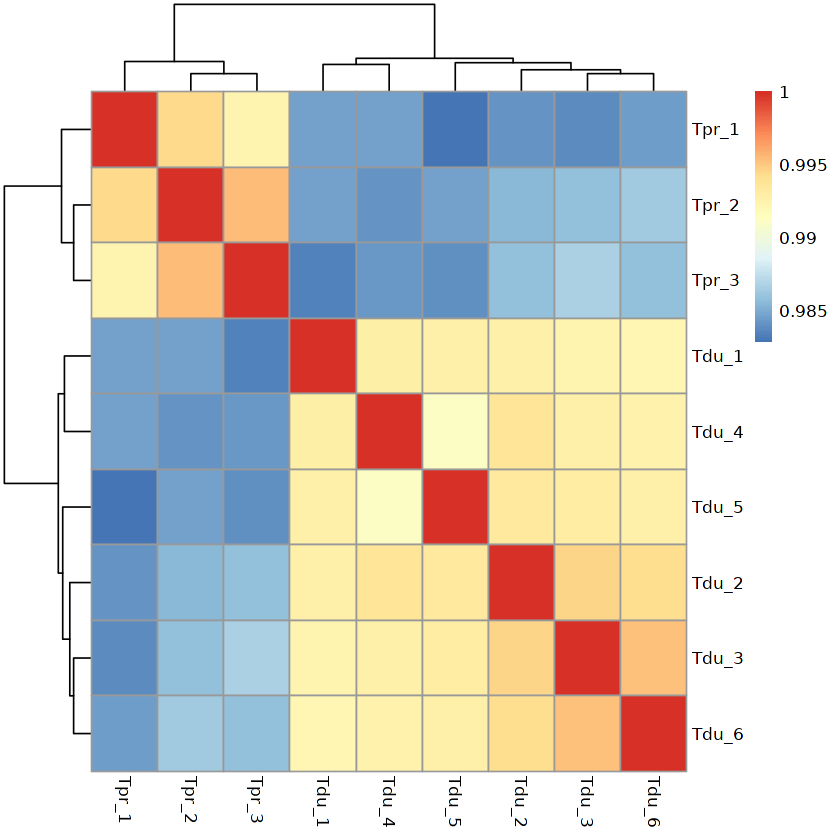

In [16]:
## Hierarchical clustering
## Extract the rlog matrix from the object
rld_mat <- assay(rld)
## Compute pairwise correlation values
rld_cor <- cor(rld_mat)
## Plot heatmap
pheatmap(rld_cor)

# Based on the quality control analysis, Tdu samples are clustered together irrespective of the population. Tpr samples are clustered together. Therefore, we will perform 1 batch of DE analysis between Tdu (combine data from two populations!) and Tpr.

# Now, let's perform the DE analysis!

In [17]:
## Creat DESeq object
## its called dds_new, as design are changed from population to species
dds_new <- DESeqDataSetFromMatrix(countData = data, colData = meta, design = ~ species)

In [18]:
## Run DE analysis
dds_new <- DESeq(dds_new)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



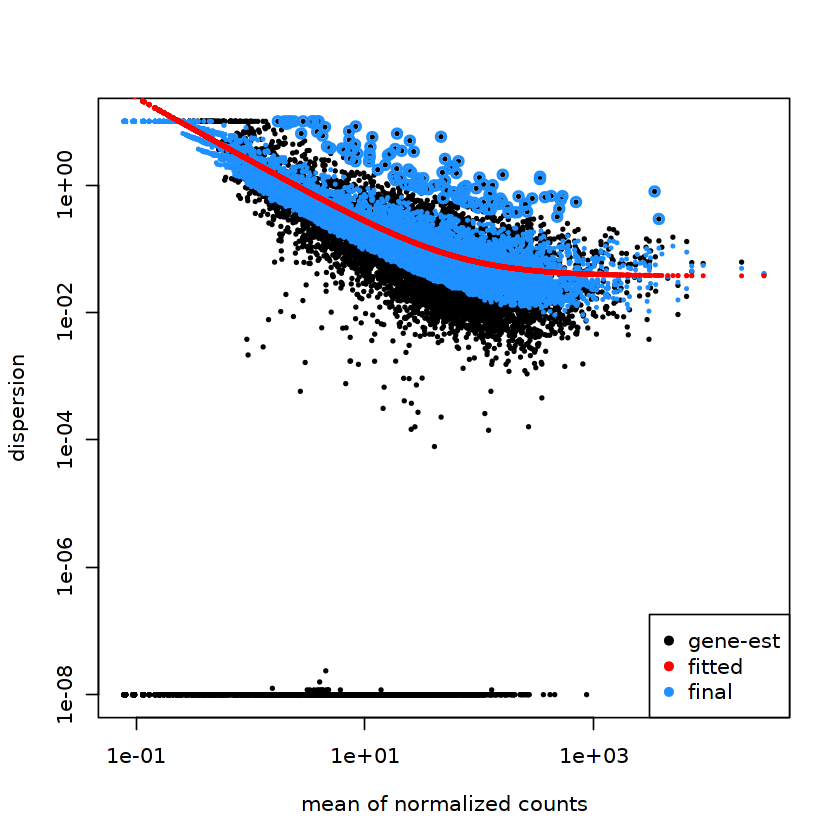

In [19]:
plotDispEsts(dds_new)

### This is a good plot to examine to ensure your data is a good fit for the DESeq2 model. You expect your data to generally scatter around the curve, with the dispersion decreasing with increasing mean expression levels.

In [20]:
## Define contrasts, extract results table, and shrink the log2 fold changes
## Tpr (the second element) is the baseline;
## cutoff of adjusted p-value (FDR) is set as 0.05
contrast <- c("species", "Tdu", "Tpr")
res_table_unshrunken <- results(dds_new, contrast=contrast, alpha = 0.05)
res_table <- lfcShrink(dds_new, contrast=contrast, res=res_table_unshrunken)

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895



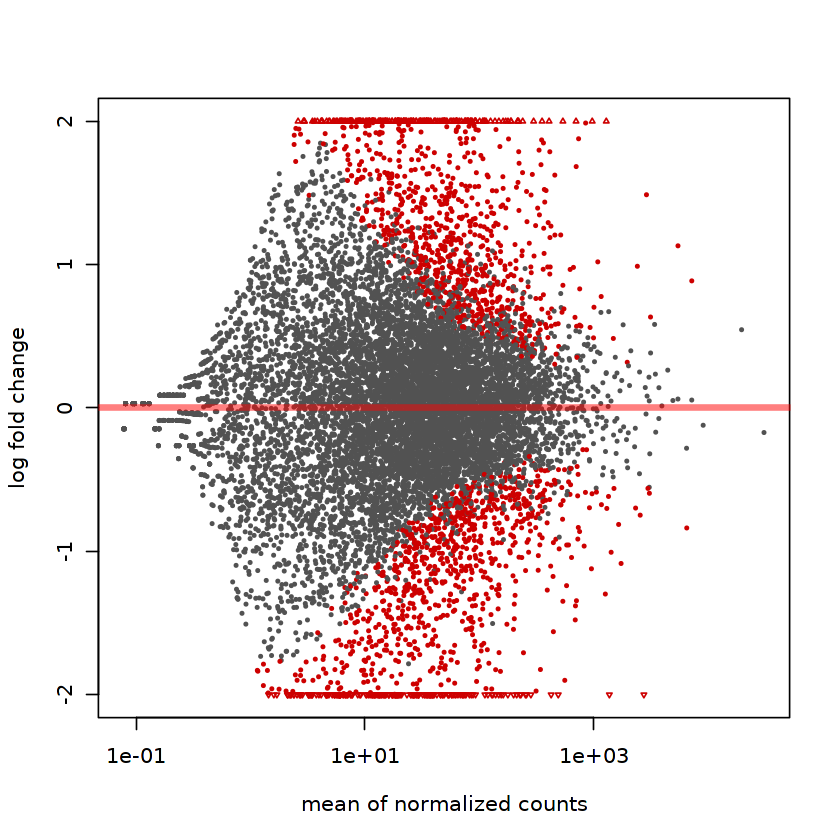

In [21]:
plotMA(res_table, ylim=c(-2,2))

In [22]:
summary(res_table)


out of 11661 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 987, 8.5%
LFC < 0 (down)     : 1030, 8.8%
outliers [1]       : 11, 0.094%
low counts [2]     : 904, 7.8%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [23]:
## count the number of NA in column padj
sum(is.na(res_table$padj))

[1] 1118

### Extracting significant differentially expressed genes

In [24]:
sig <- subset(res_table, padj < 0.05)
write.table(sig, "DESeq2_DE_Tdu_Tpr.txt", sep="\t", quote=F, row.names = TRUE)

In [28]:
## DE genes with higher expression in Tdu
## Tpr is the baseline; log2FoldChange > 0 indicates higher expression in Tdu
sig_Tdu_higher <- subset(res_table, padj < 0.05 & log2FoldChange > 0)
write.table(sig_Tdu_higher, "DESeq2_DE_higher_Tdu.txt", sep="\t", quote=F, row.names = TRUE)

In [29]:
## DE genes with higher expression in Tpr
## Tpr is the baseline; log2FoldChange < 0 indicates higher expression in Tpr
sig_Tpr_higher <- subset(res_table, padj < 0.05 & log2FoldChange < 0)
write.table(sig_Tpr_higher, "DESeq2_DE_higher_Tpr.txt", sep="\t", quote=F, row.names = TRUE)

In [30]:
## non-DE genes
none_sig <- subset(res_table, padj >= 0.05)
write.table(none_sig, "DESeq2_none-DE_Tdu_Tpr.txt", sep="\t", quote=F, row.names = TRUE)